In [92]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import preprocessing
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, udf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics 

In [93]:
spark = SparkSession.builder \
           .appName('Tuning Text Classification Model') \
           .config("spark.jars", "mysql-connector-j-8.0.32.jar")\
           .config("spark.driver.memory", "6g") \
           .config("spark.executor.memory", "8g") \
           .getOrCreate()

In [94]:
text_classification_data = spark.read \
                                .format("jdbc") \
                                .option("driver","com.mysql.cj.jdbc.Driver") \
                                .option("url", "jdbc:mysql://web-database/Web") \
                                .option("dbtable", "textClassification") \
                                .option("user", "root") \
                                .option("password", "123") \
                                .load()

In [95]:
text_classification_data.show(10)

+-----+--------+--------------------+
|tagId|category|        descriptions|
+-----+--------+--------------------+
|    1|  Sports|French maestros R...|
|    2|  Sports|SOUTHLAKE, Texas ...|
|    3|Sci/Tech|A Soyuz spacecraf...|
|    4|Sci/Tech|America #39;s ear...|
|    5|Sci/Tech|Dell Inc. said ye...|
|    6|Business|A financial indus...|
|    7|Business|Speculation runs ...|
|    8|Business|Apple Computer sa...|
|    9|  Sports|Titleholder Ernie...|
|   10|  Sports|Sergio Garcia wal...|
+-----+--------+--------------------+
only showing top 10 rows



In [96]:
text_classification_data = text_classification_data.select('category', 'descriptions')
text_classification_data = text_classification_data.dropna(subset = ('category'))

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [98]:
preprocessed_df = preprocessing(text_classification_data, 'descriptions')

In [99]:
preprocessed_df.show(5)

+--------+--------------------+--------------------+--------------------+
|category|        descriptions|  descriptions_words|            filtered|
+--------+--------------------+--------------------+--------------------+
|  Sports|French maestros R...|[french, maestros...|[french, maestros...|
|  Sports|SOUTHLAKE, Texas ...|[southlake, texas...|[southlake, texas...|
|Sci/Tech|A Soyuz spacecraf...|[a, soyuz, spacec...|[soyuz, spacecraf...|
|Sci/Tech|America #;s earli...|[america, s, earl...|[america, earlies...|
|Sci/Tech|Dell Inc. said ye...|[dell, inc, say, ...|[dell, inc, say, ...|
+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [102]:
hashing_tf = HashingTF(inputCol = "filtered", outputCol = "raw_features")
featurized_data = hashing_tf.transform(preprocessed_df)

In [103]:
featurized_data.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+
|category|        descriptions|  descriptions_words|            filtered|        raw_features|
+--------+--------------------+--------------------+--------------------+--------------------+
|  Sports|French maestros R...|[french, maestros...|[french, maestros...|(262144,[14870,25...|
|  Sports|SOUTHLAKE, Texas ...|[southlake, texas...|[southlake, texas...|(262144,[16306,17...|
|Sci/Tech|A Soyuz spacecraf...|[a, soyuz, spacec...|[soyuz, spacecraf...|(262144,[10326,12...|
|Sci/Tech|America #;s earli...|[america, s, earl...|[america, earlies...|(262144,[1303,411...|
|Sci/Tech|Dell Inc. said ye...|[dell, inc, say, ...|[dell, inc, say, ...|(262144,[16713,81...|
+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [104]:
idf = IDF(inputCol = "raw_features", outputCol = "features")
idf_vectorizer = idf.fit(featurized_data)
rescaled_data = idf_vectorizer.transform(featurized_data) 

In [105]:
rescaled_data.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|        descriptions|  descriptions_words|            filtered|        raw_features|            features|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Sports|French maestros R...|[french, maestros...|[french, maestros...|(262144,[14870,25...|(262144,[14870,25...|
|  Sports|SOUTHLAKE, Texas ...|[southlake, texas...|[southlake, texas...|(262144,[16306,17...|(262144,[16306,17...|
|Sci/Tech|A Soyuz spacecraf...|[a, soyuz, spacec...|[soyuz, spacecraf...|(262144,[10326,12...|(262144,[10326,12...|
|Sci/Tech|America #;s earli...|[america, s, earl...|[america, earlies...|(262144,[1303,411...|(262144,[1303,411...|
|Sci/Tech|Dell Inc. said ye...|[dell, inc, say, ...|[dell, inc, say, ...|(262144,[16713,81...|(262144,[16713,81...|
+--------+--------------------+--------------------+--------------------

In [106]:
labelEncoder = StringIndexer(inputCol = 'category',outputCol = 'label').fit(rescaled_data)

In [107]:
labelEncoder.transform(rescaled_data).select("category", 'label').distinct().show()

+--------+-----+
|category|label|
+--------+-----+
|Sci/Tech|  1.0|
|  Sports|  2.0|
|   World|  3.0|
|Business|  0.0|
+--------+-----+



In [108]:
label_dict = {'Business': 0.0,
             'Sci/Tech': 1.0,
             'Sports': 2.0,
             'World': 3.0}

In [109]:
df = labelEncoder.transform(rescaled_data)

In [110]:
df.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|category|        descriptions|  descriptions_words|            filtered|        raw_features|            features|label|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  Sports|French maestros R...|[french, maestros...|[french, maestros...|(262144,[14870,25...|(262144,[14870,25...|  2.0|
|  Sports|SOUTHLAKE, Texas ...|[southlake, texas...|[southlake, texas...|(262144,[16306,17...|(262144,[16306,17...|  2.0|
|Sci/Tech|A Soyuz spacecraf...|[a, soyuz, spacec...|[soyuz, spacecraf...|(262144,[10326,12...|(262144,[10326,12...|  1.0|
|Sci/Tech|America #;s earli...|[america, s, earl...|[america, earlies...|(262144,[1303,411...|(262144,[1303,411...|  1.0|
|Sci/Tech|Dell Inc. said ye...|[dell, inc, say, ...|[dell, inc, say, ...|(262144,[16713,81...|(262144,[16713,81...|  1.0|
+--------+--------------

In [111]:
trainDF, testDF = df.randomSplit((0.7,0.3), seed = 2)

In [112]:
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'label',
                        family = "multinomial",
                        regParam = 0.3,
                        elasticNetParam = 0,
                        maxIter = 40)
lrModel = lr.fit(trainDF)
predictions = lrModel.transform(testDF)

In [113]:
predictions.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|category|        descriptions|  descriptions_words|            filtered|        raw_features|            features|label|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|Business|" A Canadian cour...|[a, canadian, cou...|[canadian, court,...|(262144,[19018,25...|(262144,[19018,25...|  0.0|[1.98763154320979...|[0.82477378482439...|       0.0|
|Business|" A UnitedStates ...|[a, unitedstates,...|[unitedstates, ba...|(262144,[9633,978...|(262144,[9633,978...|  0.0|[3.77295452996862...|[0.97847853704762...|       0.0|
|Business|" A dispute betwe...|[a, dispute, betw...|[dispute, northwe...|(262144,[5765,699...|(262144,[5765,699...|  0.0|[5.7

In [82]:
evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
f1_score = metrics.weightedFMeasure(beta = 1.0)
print("F1 Score:", f1_score)

precision = metrics.weightedPrecision
print("Precision:", precision)

recall = metrics.weightedRecall
print("Recall:", recall)

Accuracy: 0.8847997485396967


/usr/local/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


F1 Score: 0.884531452395511
Precision: 0.8845719377389786
Recall: 0.8847997485396967


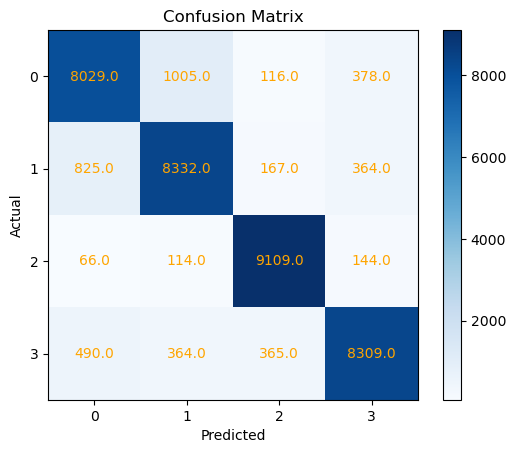

In [83]:
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_np = np.array(confusion_matrix.toArray())
labels = [str(i) for i in range(confusion_matrix.numRows)]

plt.imshow(confusion_matrix_np, cmap = 'Blues')
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, confusion_matrix_np[i, j], ha = 'center', va = 'center', color = 'orange')

plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [118]:
from pyspark.sql.types import *
example1 = [(1, "President Xi Jinping says he doesn't want a hodgepodge 'street stall economy' in Beijing, even as China's youth unemployment rates hit a record high"),
            (2, "Tech titans who are trying to live forever might soon have new ammunition: Next-gen anti-aging pills"),
            (3, "Bank of England governor says the UK is facing a wage-price spiral"), 
            (4, "Congratulation Erling Haaland who score 2 goals last match with Manchester United")]
schema = StructType([StructField("post_id", StringType(), True)\
                    ,StructField("descriptions", StringType(), True)])
example1 = spark.createDataFrame(data = example1, schema = schema)
example1 = preprocessing(example1.select('descriptions'), 'descriptions')
featurized_example = hashing_tf.transform(example1)
rescaled_example = idf_vectorizer.transform(featurized_example) 

In [119]:
rescaled_example.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [120]:
pred_example1 = lrModel.transform(rescaled_example)
pred_example1.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        descriptions|  descriptions_words|            filtered|        raw_features|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|President Xi Jinp...|[president, xi, j...|[president, xi, j...|(262144,[37131,66...|(262144,[37131,66...|[0.92790114622585...|[0.48771046799863...|       0.0|
|Tech titans who a...|[tech, titans, wh...|[tech, titans, tr...|(262144,[24549,33...|(262144,[24549,33...|[0.03308669485945...|[0.22800121118917...|       1.0|
|Bank of England g...|[bank, of, englan...|[bank, england, g...|(262144,[47552,83...|(262144,[47552,83...|[0.79576450181661...|[0.48594230719680...|       0.0|
|Congratulation Er...|[congratulation, .